## Моделирование VaR одного актива
1. Работа с временными рядами
2. Риск-метрики
   - VaR
   - Expected Shortfall
3. Различные подходы
   - Исторический
   - Параметрический
   - Теория экстремальных значений
   - Модели GARCH
   - Фильтрация временных рядов
4. Бектестирование
   - Биномиальный тест
    


In [132]:
import numpy as np
import pandas as pd
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("bmh")
plt.rcParams['font.family'] = 'DejaVu Sans'

## Данные 

### Загрузка и визуализация временных рядов

In [ ]:
# !pip install yfinance

In [133]:
import yfinance as yf

prices = yf.download('AAPL','2018-01-01','2021-12-31')

prices.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,41.075401,102223600
2018-01-03,43.132500,43.637501,42.990002,43.057499,41.068249,118071600
2018-01-04,43.134998,43.367500,43.020000,43.257500,41.259018,89738400
2018-01-05,43.360001,43.842499,43.262501,43.750000,41.728752,94640000
2018-01-08,43.587502,43.902500,43.482498,43.587502,41.573769,82271200


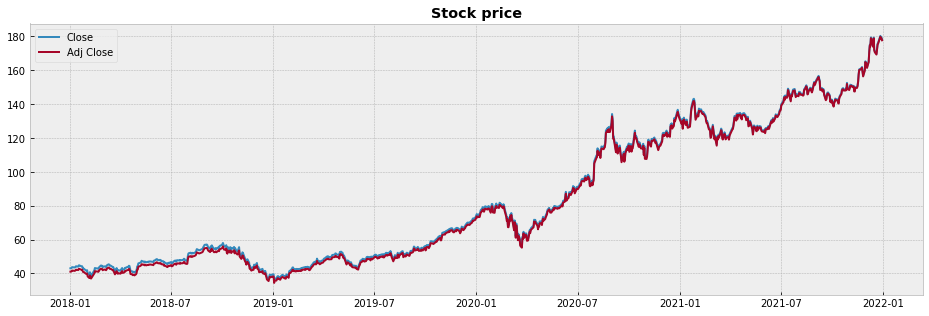

In [134]:
plot_fields =  ['Close', 'Adj Close']

fig = plt.figure(figsize=(16, 5))

plt.plot(prices[plot_fields])
plt.legend(plot_fields)

plt.title("Stock price", weight="bold")

plt.show()

### Предобработка

In [135]:
print(prices.index)

prices.index = prices.index.to_period(freq='d')

print(prices.index)

DatetimeIndex(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
               '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11',
               '2018-01-12', '2018-01-16',
               ...
               '2021-12-16', '2021-12-17', '2021-12-20', '2021-12-21',
               '2021-12-22', '2021-12-23', '2021-12-27', '2021-12-28',
               '2021-12-29', '2021-12-30'],
              dtype='datetime64[ns]', name='Date', length=1007, freq=None)
PeriodIndex(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
             '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11',
             '2018-01-12', '2018-01-16',
             ...
             '2021-12-16', '2021-12-17', '2021-12-20', '2021-12-21',
             '2021-12-22', '2021-12-23', '2021-12-27', '2021-12-28',
             '2021-12-29', '2021-12-30'],
            dtype='period[D]', name='Date', length=1007, freq='D')


In [136]:
price = prices['Adj Close']

price.head()

Date
2018-01-02    41.075401
2018-01-03    41.068249
2018-01-04    41.259018
2018-01-05    41.728752
2018-01-08    41.573769
Freq: D, Name: Adj Close, dtype: float64

In [137]:
dX = price.diff() 

ret_log = np.log(price).diff()

ret = price.pct_change() 

ret

Date
2018-01-02         NaN
2018-01-03   -0.000174
2018-01-04    0.004645
2018-01-05    0.011385
2018-01-08   -0.003714
                ...   
2021-12-23    0.003644
2021-12-27    0.022975
2021-12-28   -0.005767
2021-12-29    0.000502
2021-12-30   -0.006578
Freq: D, Name: Adj Close, Length: 1007, dtype: float64

In [138]:
ret = ret.dropna()

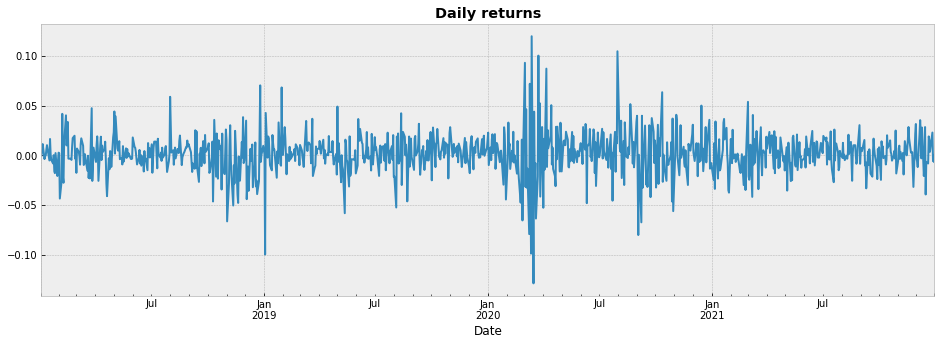

In [139]:
fig = plt.figure(figsize=(16, 5))

ret.plot()
plt.title("Daily returns", weight="bold")

plt.show()

### Построение гистограмм и графика Квантиль-Квантиль (Q-Q plot)

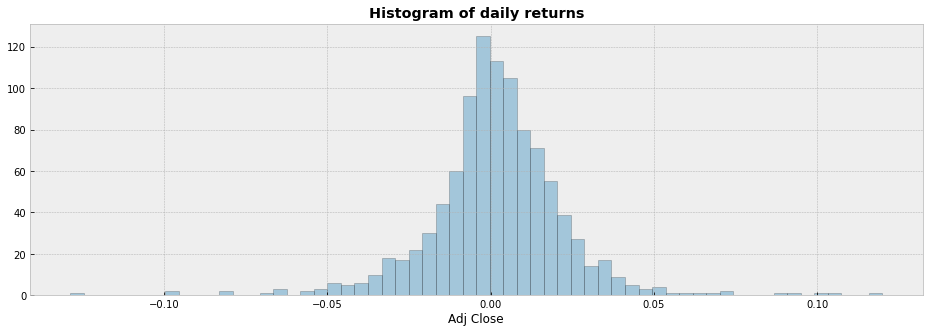

In [141]:
fig = plt.figure(figsize=(16, 5))

sns.distplot(ret, hist=True, kde=False, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.title("Histogram of daily returns", weight="bold")

plt.show()

Проверим является ли распределение доходносте нормальным

In [142]:
import scipy.stats as ss

params_norm = ss.norm.fit(ret)

print(params_norm)

(0.001671900113971089, 0.02070943420563533)


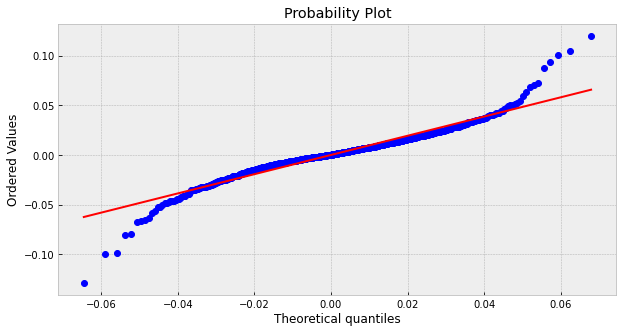

In [143]:
fig = plt.figure(figsize=(10, 5))

ss.probplot(ret, dist=ss.norm(*params_norm), plot=plt)

plt.show()

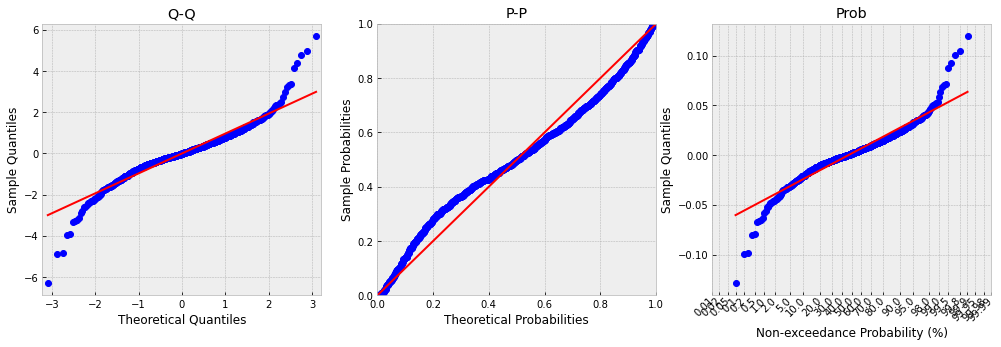

In [144]:
import statsmodels.graphics.gofplots
pp = statsmodels.graphics.gofplots.ProbPlot(ret, fit=True)

fig = plt.figure(figsize=(17, 5))

plt1 = fig.add_subplot(1,3,1)
plt2 = fig.add_subplot(1,3,2)
plt3 = fig.add_subplot(1,3,3)

pp.qqplot(ax=plt1.axes, line='r')
plt1.set_title('Q-Q')

pp.ppplot(ax=plt2.axes, line='45')
plt2.set_title('P-P')

pp.probplot(ax=plt3.axes, line='r')
plt3.set_title('Prob')

plt.show()

## Риск-метрики

### Value-at-Risk 

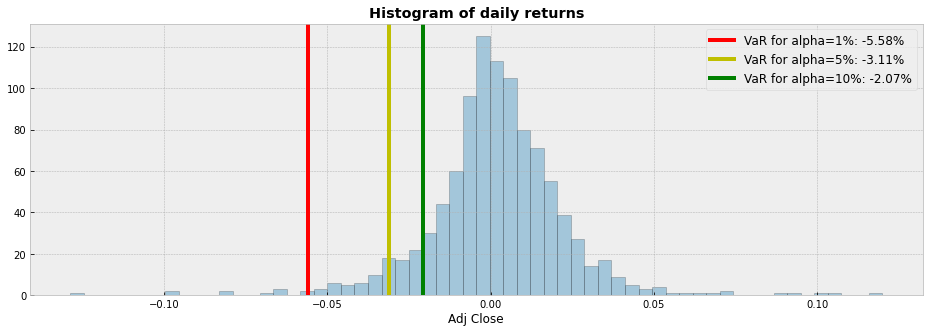

In [145]:
VaR_HS_01 = ret.quantile(0.01)
VaR_HS_05 = ret.quantile(0.05)
VaR_HS_10 = ret.quantile(0.10)

fig = plt.figure(figsize=(16, 5))

sns.distplot(ret, hist=True, kde=False, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.axvline(x=VaR_HS_01, linewidth=4, color="r")
plt.axvline(x=VaR_HS_05, linewidth=4, color="y")
plt.axvline(x=VaR_HS_10, linewidth=4, color="g")

plt.title("Histogram of daily returns", weight="bold")

plt.legend(['VaR for alpha=1%: {:.2f}%'.format(100*VaR_HS_01),
            'VaR for alpha=5%: {:.2f}%'.format(100*VaR_HS_05),
            'VaR for alpha=10%: {:.2f}%'.format(100*VaR_HS_10)], fontsize=12)

plt.show()

### Expected Shortfall 

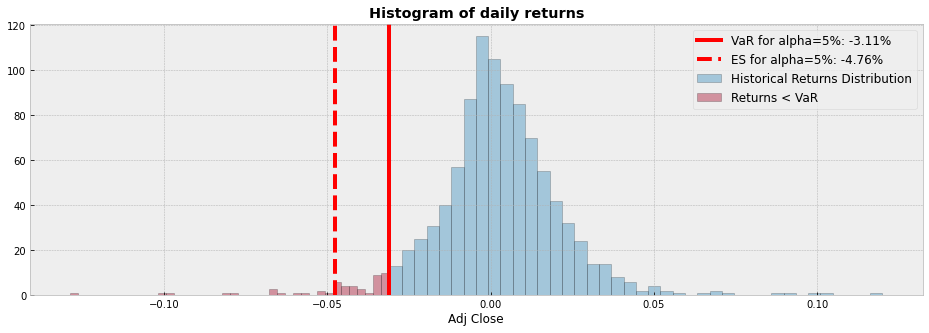

In [146]:
alpha = 0.05

VaR_HS = ret.quantile(alpha)
ES_HS = ret[ret < VaR_HS].mean()

fig = plt.figure(figsize=(16, 5))

sns.distplot(ret[ret >= VaR_HS], hist=True, kde=False, 
             bins=40,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

sns.distplot(ret[ret < VaR_HS], hist=True, kde=False, 
             bins=40,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.axvline(x=VaR_HS, linewidth=4, color="r")
plt.axvline(ES_HS, linewidth=4, color='red', linestyle='dashed')

plt.title("Histogram of daily returns", weight="bold")
plt.legend(['VaR for alpha=5%: {:.2f}%'.format(100*VaR_HS),
            'ES for alpha=5%: {:.2f}%'.format(100*ES_HS),
            'Historical Returns Distribution', 
            'Returns < VaR'], fontsize=12)

plt.show()

## Различные подходы

### Исторический (Historical simulation)

In [ ]:
def calculate_VaR_HS(ret, alpha=0.05):

    return ret.quantile(alpha)

In [ ]:
def calc_VaR(r, VaR_fun, L_history=252, level=0.05):
    VaR = np.full(r.size, np.nan)
    
    for i in range(L_history, len(r)):
        history = r[i - L_history: i]
        VaR[i] = VaR_fun(history, level)
        
    return pd.Series(data=VaR, index=r.index, name=VaR_fun.__name__)

In [147]:
VaR_HS = calc_VaR(ret, calculate_VaR_HS, L_history=252, level=alpha)

VaR_HS

Date
2018-01-03         NaN
2018-01-04         NaN
2018-01-05         NaN
2018-01-08         NaN
2018-01-09         NaN
                ...   
2021-12-23   -0.025638
2021-12-27   -0.025638
2021-12-28   -0.025638
2021-12-29   -0.025638
2021-12-30   -0.025638
Freq: D, Name: calculate_VaR_HS, Length: 1006, dtype: float64

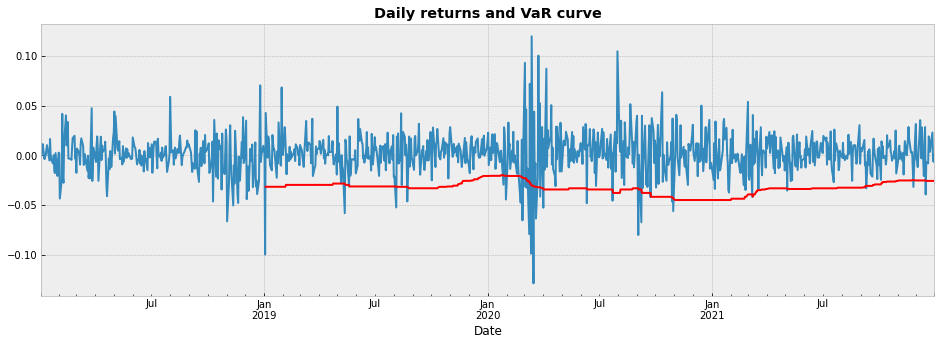

In [148]:
fig = plt.figure(figsize=(16, 5))

ret.plot()
VaR_HS.plot(color='r')

plt.title("Daily returns and VaR curve", weight="bold")

plt.show()

### Параметрический (Parametric estimation)

#### Нормальное распределение

In [149]:
import scipy.stats as ss

params_norm = ss.norm.fit(ret)
norm_mean, norm_sigma = params_norm

VaR_norm = ss.norm.ppf(alpha, norm_mean, norm_sigma)
ES_norm = ss.norm.expect(loc=norm_mean, scale=norm_sigma, ub=VaR_norm, conditional=True)

print('Estimated parameters: mean={:.2f}, scale={:.2f}'.format(norm_mean, norm_sigma))
print('Value-at-Risk: {:.2f}%'.format(100*VaR_norm))
print('Expected Shortfall: {:.2f}%'.format(100*ES_norm))

Estimated parameters: mean=0.00, scale=0.02
Value-at-Risk: -3.24%
Expected Shortfall: -4.10%


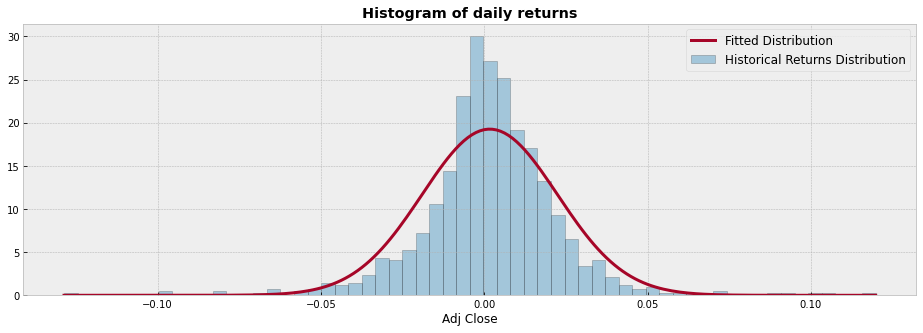

In [150]:
fig = plt.figure(figsize=(16, 5))

x = np.linspace(ret.min(), ret.max(), 200)

y_pdf = ss.norm.pdf(x, *params_norm)

sns.distplot(ret, hist=True, kde=False, 
             bins=60, norm_hist=True,
             hist_kws={'edgecolor':'black'})
plt.plot(x, y_pdf, linewidth=3)

plt.title("Histogram of daily returns", weight="bold")
plt.legend(['Fitted Distribution', 'Historical Returns Distribution'], fontsize=12)

plt.show()

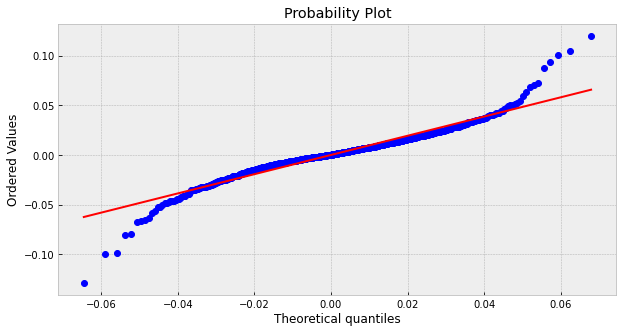

In [151]:
fig = plt.figure(figsize=(10, 5))
ss.probplot(ret, dist=ss.norm(*params_norm), plot=plt)
plt.show()

#### Распределение Стьюдента

In [152]:
params_t = ss.t.fit(ret)
t_df, t_mean, t_sigma = params_t

VaR_t = ss.t.ppf(alpha, t_df, t_mean, t_sigma)
ES_t = ss.t.expect(args=(t_df,), loc=t_mean, scale=t_sigma, ub=VaR_t, conditional=True)

print('Estimated parameters: df={:.2f}, mean={:.2f}, scale={:.2f}'.format(t_df, t_mean, t_sigma))
print('Value-at-Risk: {:.2f}%'.format(100*VaR_t))
print('Expected Shortfall: {:.2f}%'.format(100*ES_t))

Estimated parameters: df=3.16, mean=0.00, scale=0.01
Value-at-Risk: -2.88%
Expected Shortfall: -4.78%


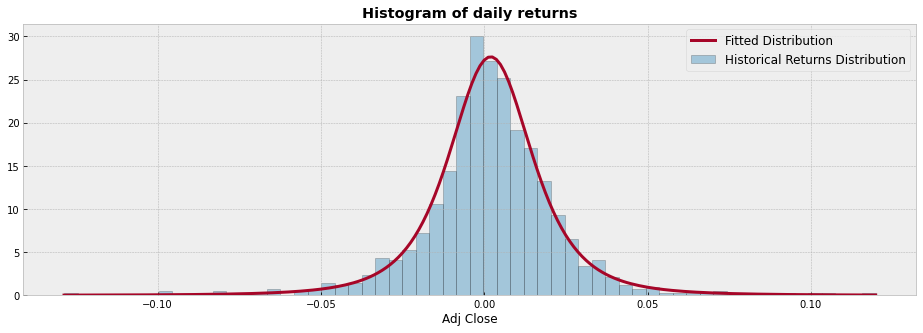

In [153]:
fig = plt.figure(figsize=(16, 5))

x = np.linspace(ret.min(), ret.max(), 200)

y_pdf = ss.t.pdf(x, *params_t)

sns.distplot(ret, hist=True, kde=False, 
             bins=60, norm_hist=True,
             hist_kws={'edgecolor':'black'})
plt.plot(x, y_pdf, linewidth=3)

plt.title("Histogram of daily returns", weight="bold")
plt.legend(['Fitted Distribution', 'Historical Returns Distribution'], fontsize=12)


plt.show()

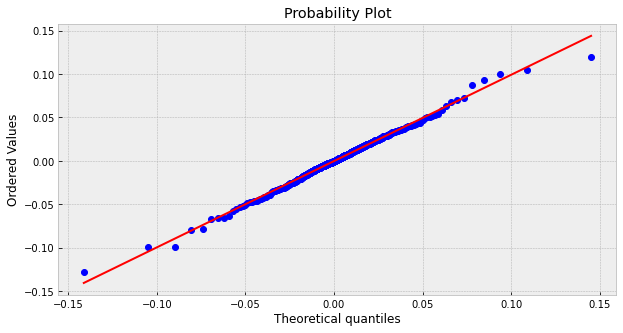

In [154]:
fig = plt.figure(figsize=(10, 5))
ss.probplot(ret, dist=ss.t(*params_t), plot=plt)
plt.show()

In [ ]:
def calculate_VaR_normal(ret, alpha=0.05):

    params_norm = ss.norm.fit(ret)
    
    return ss.norm.ppf(alpha, *params_norm)


def calculate_VaR_t(ret, alpha=0.05):

    params_t = ss.t.fit(ret)
    
    return ss.t.ppf(alpha, *params_t)

In [155]:
VaR_norm = calc_VaR(ret, calculate_VaR_normal, L_history=252, level=alpha)

VaR_t = calc_VaR(ret, calculate_VaR_t, L_history=252, level=alpha)

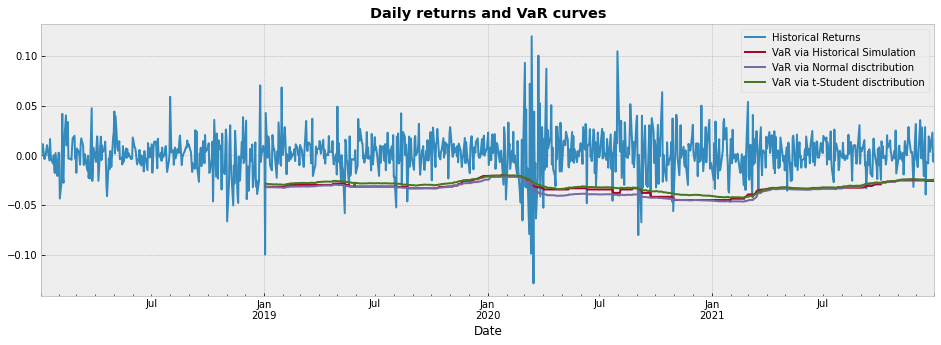

In [156]:
fig = plt.figure(figsize=(16, 5))

ret.plot()
VaR_HS.plot()
VaR_norm.plot()
VaR_t.plot()

plt.title("Daily returns and VaR curves", weight="bold")

plt.legend(['Historical Returns',
            'VaR via Historical Simulation',
            'VaR via Normal disctribution',
            'VaR via t-Student disctribution'])

plt.show()

### Теория экстремальных значений

[Extreme Value Theory](https://www.financialriskforecasting.com/files/Danielsson-Financial-Risk-Forecasting-Slides-9.pdf)

#### Блочные максимумы (Block maxima) и Обобщенное распределение экстремальных значений (Generalized Extreme Value Distribution (GEV))


Семплируем потери по периодам (напр. неделя, месяц и т.д.)

In [157]:
maximas = ret.resample('W').min()

In [158]:
ret

Date
2018-01-03   -0.000174
2018-01-04    0.004645
2018-01-05    0.011385
2018-01-08   -0.003714
2018-01-09   -0.000115
                ...   
2021-12-23    0.003644
2021-12-27    0.022975
2021-12-28   -0.005767
2021-12-29    0.000502
2021-12-30   -0.006578
Freq: D, Name: Adj Close, Length: 1006, dtype: float64

In [159]:
maximas

Date
2018-01-01/2018-01-07   -0.000174
2018-01-08/2018-01-14   -0.003714
2018-01-15/2018-01-21   -0.005082
2018-01-22/2018-01-28   -0.017851
2018-01-29/2018-02-04   -0.043390
                           ...   
2021-11-29/2021-12-05   -0.011725
2021-12-06/2021-12-12   -0.002970
2021-12-13/2021-12-19   -0.039264
2021-12-20/2021-12-26   -0.008122
2021-12-27/2022-01-02   -0.006578
Freq: W-SUN, Name: Adj Close, Length: 209, dtype: float64

In [160]:
params_genextreme = ss.genextreme.fit(maximas)
c, loc, scale = params_genextreme
xi = -c

VaR_genextreme = loc + scale / xi * (1 - (-5*np.log(1-alpha)) ** (-xi) )
# VaR_genextreme = ss.genextreme.ppf(alpha**(-5), *params_genextreme)


print('Estimated parameters: c={:.2f}, mean={:.2f}, scale={:.2f}'.format(c, loc, scale))
print('Value-at-Risk: {:.2f}%'.format(100*VaR_genextreme))
# print('Expected Shortfall: {:.2f}%'.format(100*ES_genpareto))

Estimated parameters: c=0.58, mean=-0.02, scale=0.02
Value-at-Risk: -4.12%


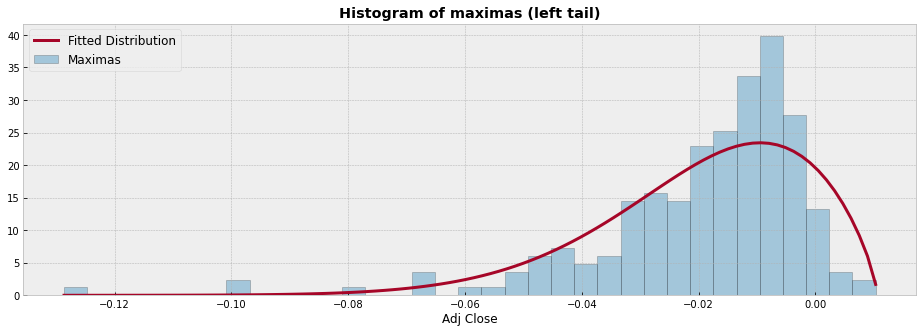

In [161]:
fig = plt.figure(figsize=(16, 5))

x = np.linspace(maximas.min(), maximas.max(), 100)

y_pdf = ss.genextreme.pdf(x, *params_genextreme)

sns.distplot(maximas, hist=True, kde=False, 
             bins=35, norm_hist=True,
             hist_kws={'edgecolor':'black'})
plt.plot(x, y_pdf, linewidth=3)

plt.title("Histogram of maximas (left tail)", weight="bold")
plt.legend(['Fitted Distribution', 'Maximas'], fontsize=12)

plt.show()

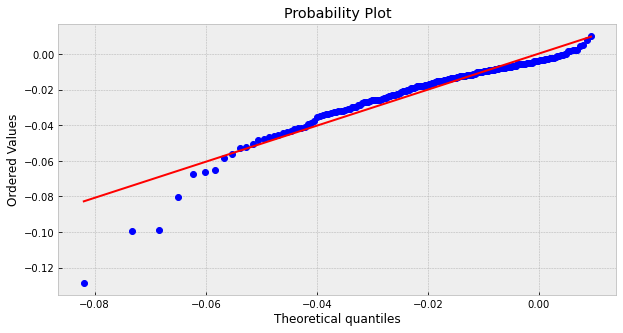

In [162]:
fig = plt.figure(figsize=(10, 5))
ss.probplot(maximas, dist=ss.genextreme(*params_genextreme), plot=plt)
plt.show()

#### Распределение сверх порогового значения (Excess Distribution Over a Threshold)

In [ ]:
u = ret.quantile(0.2)

print(u)

ret_tail = ret[ret <= u]

In [163]:
params_genpareto = ss.genpareto.fit(-ret_tail, loc=0)
c, loc, scale = params_genpareto

VaR_genpareto = u - scale / c * ((alpha/(ret <= u).mean())**(-c) - 1)
ES_genpareto = VaR_genpareto / (1 - c) - (scale - c*u) / (1 - c)

print('Estimated parameters: c={:.2f}, mean={:.2f}, scale={:.2f}'.format(c, loc, scale))
print('Value-at-Risk: {:.2f}%'.format(100*VaR_genpareto))
print('Expected Shortfall: {:.2f}%'.format(100*ES_genpareto))

Estimated parameters: c=0.16, mean=0.01, scale=0.01
Value-at-Risk: -3.05%
Expected Shortfall: -5.32%


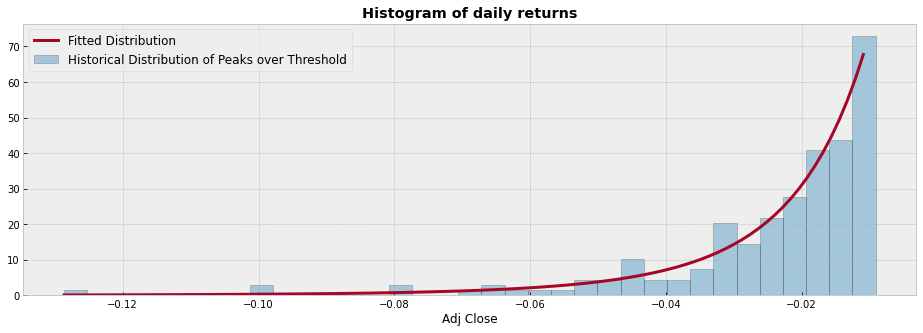

In [164]:
fig = plt.figure(figsize=(16, 5))

x = np.linspace(ret_tail.min(), ret_tail.max()*1.2, 100)

y_pdf = ss.genpareto.pdf(-x, *params_genpareto)

sns.distplot(ret_tail, hist=True, kde=False, 
             bins=35, norm_hist=True,
             hist_kws={'edgecolor':'black'})
plt.plot(x, y_pdf, linewidth=3)

plt.title("Histogram of daily returns", weight="bold")
plt.legend(['Fitted Distribution', 'Historical Distribution of Peaks over Threshold'], fontsize=12)

plt.show()

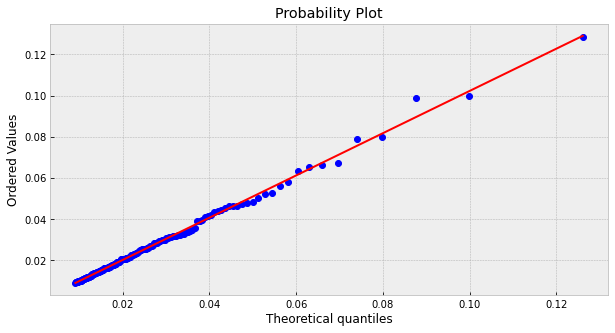

In [165]:
fig = plt.figure(figsize=(10, 5))
ss.probplot(-ret_tail, dist=ss.genpareto(*params_genpareto), plot=plt)
plt.show()

In [166]:
def calculate_VaR_pot(ret, alpha=0.05):
    
    u = ret.quantile(0.2)
    ret_tail = ret[ret <= u]

    c, loc, scale = ss.genpareto.fit(-ret_tail, loc=0)
    
    return u - scale / c * ((alpha/(ret <= u).mean())**(-c) - 1)


def calculate_VaR_maximas(ret, alpha=0.05):
    
    maximas = ret.resample('W').min()
    
    params_genextreme = ss.genextreme.fit(maximas)
    c, loc, scale = params_genextreme
    xi = -c

    return loc + scale / xi * (1 - (-5*np.log(1-alpha)) ** (-xi) )

In [167]:
VaR_pot = calc_VaR(ret, calculate_VaR_pot, L_history=252, level=alpha)
VaR_maximas = calc_VaR(ret, calculate_VaR_maximas, L_history=252, level=alpha)

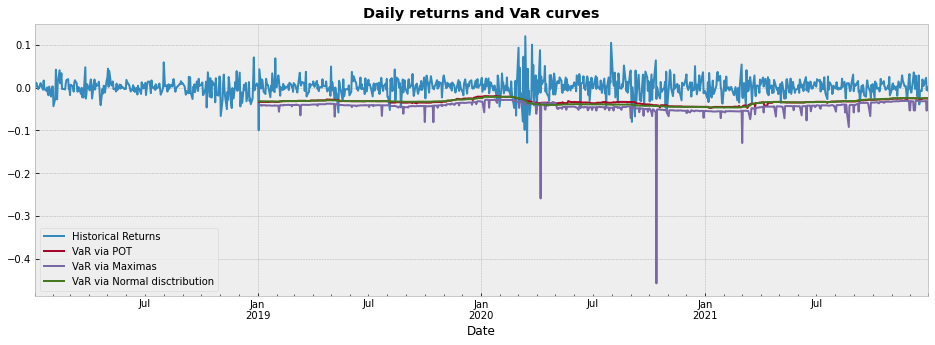

In [168]:
fig = plt.figure(figsize=(16, 5))

ret.plot()
VaR_pot.plot()
VaR_maximas.plot()
VaR_norm.plot()

plt.title("Daily returns and VaR curves", weight="bold")

plt.legend(['Historical Returns',
            'VaR via POT',
            'VaR via Maximas', 
           'VaR via Normal disctribution'])

plt.show()

### GARCH модели

#### GARCH с параметрическим распределением остатков

[Документация arch](https://arch.readthedocs.io/en/latest/univariate/introduction.html)

In [ ]:
# !pip install arch

Обучим модель

In [169]:
from arch import arch_model 

mdl = arch_model(100 * ret) # согласно документации

res = mdl.fit()

res

Iteration:      1,   Func. Count:      6,   Neg. LLF: 4899.860792179741
Iteration:      2,   Func. Count:     16,   Neg. LLF: 241368876347.2618
Iteration:      3,   Func. Count:     24,   Neg. LLF: 2410.360628841283
Iteration:      4,   Func. Count:     31,   Neg. LLF: 2465.8442924760493
Iteration:      5,   Func. Count:     37,   Neg. LLF: 2025.0961886079974
Iteration:      6,   Func. Count:     43,   Neg. LLF: 2021.7768853935956
Iteration:      7,   Func. Count:     48,   Neg. LLF: 2021.7497121110282
Iteration:      8,   Func. Count:     53,   Neg. LLF: 2021.7487381136418
Iteration:      9,   Func. Count:     58,   Neg. LLF: 2021.748685794426
Iteration:     10,   Func. Count:     63,   Neg. LLF: 2021.7486502005781
Iteration:     11,   Func. Count:     67,   Neg. LLF: 2021.748650200655
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2021.7486502005781
            Iterations: 11
            Function evaluations: 67
            Gradient evaluati

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2021.75
Distribution:                  Normal   AIC:                           4051.50
Method:            Maximum Likelihood   BIC:                           4071.15
                                        No. Observations:                 1006
Date:                Mon, Jul 25 2022   Df Residuals:                     1005
Time:                        18:30:38   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2549  5.215e-02      4.889  1.014e-06 [  0.153,  0.35

In [170]:
dist = 'skewstudent'

mdl = arch_model(100 * ret,
                    mean='HARX', lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol='Garch', p=1, o=1, q=1, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist=dist) # dist = Normal, t, skewstudent, ged

res = mdl.fit()
res

Iteration:      1,   Func. Count:     10,   Neg. LLF: 29785.9327752007
Iteration:      2,   Func. Count:     23,   Neg. LLF: 103213.75961590609
Iteration:      3,   Func. Count:     35,   Neg. LLF: 53769.13556680667
Iteration:      4,   Func. Count:     46,   Neg. LLF: 51547.447732904766
Iteration:      5,   Func. Count:     57,   Neg. LLF: 15169.927637296323
Iteration:      6,   Func. Count:     68,   Neg. LLF: 2023.427503181973
Iteration:      7,   Func. Count:     78,   Neg. LLF: 2933.5228922764327
Iteration:      8,   Func. Count:     88,   Neg. LLF: 2968.882512998038
Iteration:      9,   Func. Count:     98,   Neg. LLF: 2884.532493368188
Iteration:     10,   Func. Count:    108,   Neg. LLF: 1985.0444616495788
Iteration:     11,   Func. Count:    118,   Neg. LLF: 1980.2930817484382
Iteration:     12,   Func. Count:    127,   Neg. LLF: 1980.287436076852
Iteration:     13,   Func. Count:    136,   Neg. LLF: 1980.2869532547597
Iteration:     14,   Func. Count:    145,   Neg. LLF: 1980

                              HAR - GJR-GARCH Model Results                              
Dep. Variable:                         Adj Close   R-squared:                       0.012
Mean Model:                                  HAR   Adj. R-squared:                  0.011
Vol Model:                             GJR-GARCH   Log-Likelihood:               -1980.29
Distribution:      Standardized Skew Student's t   AIC:                           3976.57
Method:                       Maximum Likelihood   BIC:                           4015.88
                                                   No. Observations:                 1005
Date:                           Mon, Jul 25 2022   Df Residuals:                     1003
Time:                                   18:31:56   Df Model:                            2
                                  Mean Model                                  
                     coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------

Расмотрим условную волатильность и стандартизированные остатки 

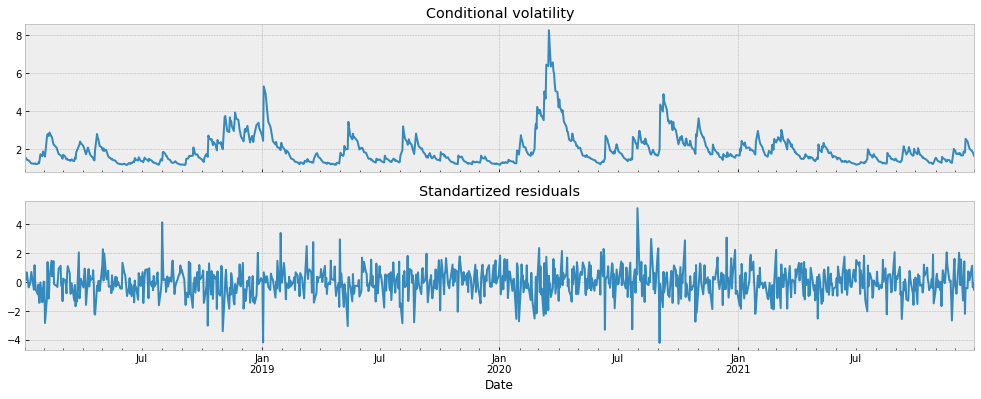

In [171]:
fig = plt.figure(figsize=(17, 6))

plt1 = fig.add_subplot(2,1,1)
plt2 = fig.add_subplot(2,1,2)

res.conditional_volatility.plot(ax=plt1.axes)
plt1.set_title('Conditional volatility')

(res.resid / res.conditional_volatility).plot(ax=plt2.axes)
plt2.set_title('Standartized residuals')

for ax in fig.get_axes():
    ax.label_outer()

plt.show()

Предсказываем условное среднее и дисперсию

In [172]:
my_forecast = res.forecast(horizon=5)

print(my_forecast.mean.tail(4))
print(my_forecast.variance.tail(4))

                 h.1      h.2       h.3       h.4       h.5
Date                                                       
2021-12-27       NaN      NaN       NaN       NaN       NaN
2021-12-28       NaN      NaN       NaN       NaN       NaN
2021-12-29       NaN      NaN       NaN       NaN       NaN
2021-12-30  0.234732  0.18871  0.191083  0.190961  0.190967
                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2021-12-27       NaN       NaN       NaN       NaN       NaN
2021-12-28       NaN       NaN       NaN       NaN       NaN
2021-12-29       NaN       NaN       NaN       NaN       NaN
2021-12-30  2.551734  2.644017  2.726311  2.805267  2.881037


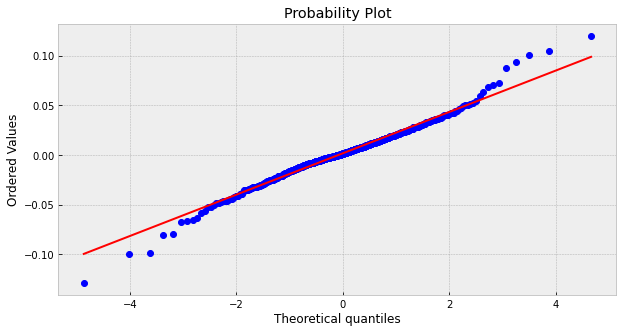

In [173]:
fig = plt.figure(figsize=(10, 5))
ss.probplot(ret, dist=mdl.distribution, sparams=(res.params[-2:],), plot=plt)
plt.show()

#### Filtered Historical Simulation

In [176]:
# обучаем модель с нормальным распределением остатков
mdl = arch_model(100 * ret,
                    mean='Constant', lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol='Garch', p=2, o=2, q=2, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist='normal')

res = mdl.fit(disp='off')

# получаем стандартизированные остатки
stand_residuals = res.resid / res.conditional_volatility
stand_residuals = stand_residuals.dropna()


# предсказываем средднее и десперсию на один шаг вперед
forecasts = res.forecast(horizon=1)
cond_mean = float(forecasts.mean.iloc[-1])
cond_var = float(forecasts.variance.iloc[-1])


# получаем предсказанные условные доходности
conditional_sr = cond_mean + np.sqrt(cond_var) * stand_residuals
conditional_sr = conditional_sr / 100


# считаем VaR как квантиль
VaR_FHS = conditional_sr.quantile(alpha)

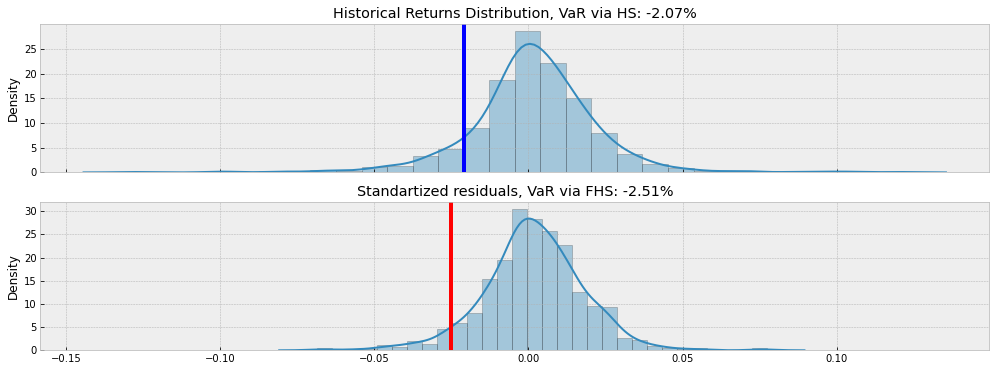

In [177]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(17, 6))

sns.distplot(ret, hist=True, kde=True, 
             bins=30, norm_hist=True,
             hist_kws={'edgecolor':'black'}, ax=ax[0])
ax[0].set_title('Historical Returns Distribution, VaR via HS: {:.2f}%'.format(100*VaR_HS_10))
ax[0].axvline(x=VaR_HS_10, linewidth=4, color="b")

sns.distplot(conditional_sr, hist=True, kde=True, 
             bins=30, norm_hist=True,
             hist_kws={'edgecolor':'black'}, ax=ax[1])
ax[1].set_title('Standartized residuals, VaR via FHS: {:.2f}%'.format(100*VaR_FHS))
ax[1].axvline(x=VaR_FHS, linewidth=4, color="r")

for ax in fig.get_axes():
    ax.label_outer()

plt.show()

In [178]:
def calculate_VaR_garch(returns, alpha):
    
    scaling_const = 10.0 / returns.std()

    dist = 'skewstudent'
    am = arch_model(scaling_const * returns,
                    mean='HARX', lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol='Garch', p=1, o=1, q=1, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist=dist) # dist = Normal, t, skewstudent, ged

    res = am.fit(update_freq=0, disp='off')

    forecasts = res.forecast(horizon=1)

    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    if dist == 'Normal':
        q = am.distribution.ppf(alpha)
    elif dist == 't' or dist == 'ged':
        q = am.distribution.ppf(alpha, res.params[-1:])
    elif dist == 'skewstudent':
        q = am.distribution.ppf(alpha, res.params[-2:])

    return_garch_forecast = cond_mean / scaling_const
    VaR_garch_forecast = (cond_mean + np.sqrt(cond_var) * q) / scaling_const

    return VaR_garch_forecast


def calculate_VaR_FHS(returns, alpha):
    
    scaling_const = 10.0 / returns.std()

    mdl = arch_model(scaling_const * returns,
                    mean='HARX', lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol='Garch', p=1, o=1, q=1, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist='normal')

    res = mdl.fit(disp='off')

   # получаем стандартизированные остатки
    stand_residuals = res.resid / res.conditional_volatility
    stand_residuals = stand_residuals.dropna()


   # предсказываем средднее и десперсию на один шаг вперед
    forecasts = res.forecast(horizon=1)
    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    # получаем предсказанные условные доходности
    conditional_sr = cond_mean + np.sqrt(cond_var) * stand_residuals
    conditional_sr = conditional_sr / scaling_const

    # считаем VaR как квантиль
    VaR_FHS = conditional_sr.quantile(alpha)

    return VaR_FHS

In [179]:
VaR_garch = calc_VaR(ret, calculate_VaR_garch, L_history=252, level=alpha)
VaR_FHS = calc_VaR(ret, calculate_VaR_FHS, L_history=252, level=alpha)

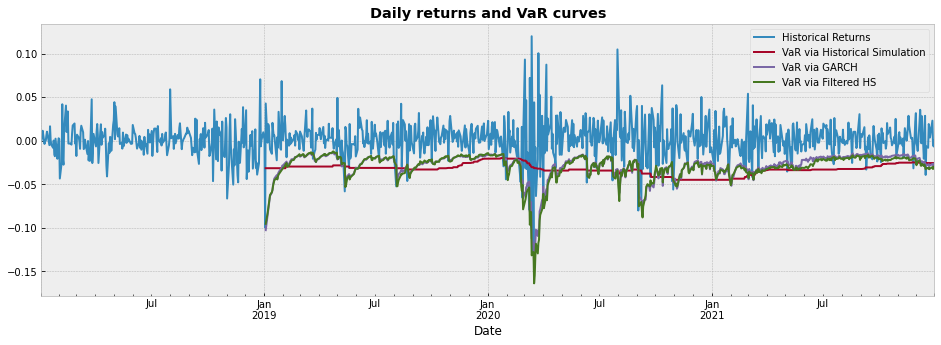

In [182]:
fig = plt.figure(figsize=(16, 5))

ret.plot()
VaR_HS.plot()
# VaR_t.plot()
VaR_garch.plot()
VaR_FHS.plot()

plt.title("Daily returns and VaR curves", weight="bold")

plt.legend(['Historical Returns',
            'VaR via Historical Simulation',
           'VaR via GARCH',
           'VaR via Filtered HS'])

plt.show()

## Бектестирование VaR

[Overview of VaR Backtesting](https://www.mathworks.com/help/risk/overview-of-var-backtesting.html)

In [183]:
def calc_hits(returns, VaRs):
    return ((VaRs - returns).dropna() > 0).values

In [184]:
hits = calc_hits(ret, VaR_t)
hits

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False,  True, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [185]:
hits.mean()

0.04376657824933687

In [ ]:
def zone(p):
    if p > 0.05:
        return 'green'
    elif p > 0.0001:
        return 'yellow'
    else:
        return 'red'

In [186]:
def backtest_VaR(r, VaR, level, L=None):
    if L is None:
        L = (~VaR.isna()).to_numpy().nonzero()[0][0];
    r = r[L:]
    VaR = VaR[L:]
    
    hits = calc_hits(r, VaR)    
    
    p_value_two_sided = ss.binom_test(sum(hits), len(hits), 1-level, alternative = 'two-sided')
    p_value_conservative = ss.binom_test(sum(hits), len(hits), 1-level, alternative = 'greater')
    print(f'Backtesting {VaR.name}:')
    print(f'The proportion of hits is {(sum(hits)/len(hits))*100:.3}% instead of expected {(1-level)*100:.3}%')
    print(f'Two-sided p-val {p_value_two_sided:.3}, one-sided: {p_value_conservative:.3}')
    print(f'{zone(p_value_two_sided)} zone\n')

In [187]:
backtest_VaR(ret, VaR_HS, 1-alpha)
backtest_VaR(ret, VaR_t, 1-alpha)
backtest_VaR(ret, VaR_garch, 1-alpha)
backtest_VaR(ret, VaR_FHS, 1-alpha)

Backtesting calculate_VaR_HS:
The proportion of hits is 4.11% instead of expected 5.0%
Two-sided p-val 0.315, one-sided: 0.888
green zone

Backtesting calculate_VaR_t:
The proportion of hits is 4.38% instead of expected 5.0%
Two-sided p-val 0.503, one-sided: 0.806
green zone

Backtesting calculate_VaR_garch:
The proportion of hits is 5.7% instead of expected 5.0%
Two-sided p-val 0.358, one-sided: 0.209
green zone

Backtesting calculate_VaR_FHS:
The proportion of hits is 5.31% instead of expected 5.0%
Two-sided p-val 0.676, one-sided: 0.373
green zone

